In [69]:
def prepare_country_stats(oecd_bli, gdp_per_capita):
    oecd_bli = oecd_bli[oecd_bli["INEQUALITY"]=="TOT"]
    oecd_bli = oecd_bli.pivot(index="Country", columns="Indicator", values="Value")
    gdp_per_capita.rename(columns={"2015": "GDP per capita"}, inplace=True)
    gdp_per_capita.set_index("Country", inplace=True)
    full_country_stats = pd.merge(left=oecd_bli, right=gdp_per_capita,
                                  left_index=True, right_index=True)
    full_country_stats.sort_values(by="GDP per capita", inplace=True)
    remove_indices = [0, 1, 6, 8, 33, 34, 35]
    keep_indices = list(set(range(36)) - set(remove_indices))
    return full_country_stats[["GDP per capita", 'Life satisfaction']].iloc[keep_indices]

In [72]:
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

In [73]:
import os
datapath = os.path.join("datasets", "lifesat", "")

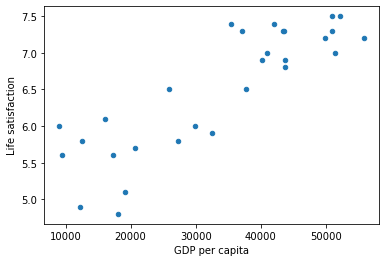

In [74]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
# Load the data
oecd_bli = pd.read_csv(datapath + "oecd_bli_2015.csv", thousands=',')
gdp_per_capita = pd.read_csv(datapath + "gdp_per_capita.csv",thousands=',',delimiter='\t',
                             encoding='latin1', na_values="n/a")

# Prepare the data
country_stats = prepare_country_stats(oecd_bli, gdp_per_capita)
X = np.c_[country_stats["GDP per capita"]]
y = np.c_[country_stats["Life satisfaction"]]

# Visualize the data
country_stats.plot(kind='scatter', x="GDP per capita", y='Life satisfaction')
plt.show()

# Select a linear model
model = sklearn.linear_model.LinearRegression()

# Train the model
model.fit(X, y)
# compute minimum and maximum on the training data
scaler = MinMaxScaler().fit(X_train)

In [75]:
import mglearn

In [76]:
def get_feature_names_from_column_transformer(col_trans):
    """Get feature names from a sklearn column transformer.
	
    The `ColumnTransformer` class in `scikit-learn` supports taking in a
    `pd.DataFrame` object and specifying `Transformer` operations on columns.
    The output of the `ColumnTransformer` is a numpy array that can used and
    does not contain the column names from the original dataframe. The class
    provides a `get_feature_names` method for this purpose that returns the
    column names corr. to the output array. Unfortunately, not all
    `scikit-learn` classes provide this method (e.g. `Pipeline`) and still
    being actively worked upon.
    
	NOTE: This utility function is a temporary solution until the proper fix is
    available in the `scikit-learn` library.
    """
    from sklearn.pipeline import Pipeline
    from sklearn.impute import SimpleImputer
    from sklearn.preprocessing import OneHotEncoder as skohe
    
	# SimpleImputer has `add_indicator` attribute that distinguishes it from other transformers
    # Encoder had `get_feature_names` attribute that distinguishes it from other transformers
	# The last transformer is ColumnTransformer's 'remainder'
    col_name = []
    for transformer_in_columns in col_trans.transformers_: 
        is_pipeline=0
        raw_col_name = list(transformer_in_columns[2])
        
        if isinstance(transformer_in_columns[1], Pipeline): 
            # if pipeline, get the last transformer
            transformer = transformer_in_columns[1].steps[-1][1]
            is_pipeline=1
        else:
            transformer = transformer_in_columns[1]
            
        try:
            if isinstance(transformer, str):
                if transformer == "passthrough":
                    names = transformer._feature_names_in[raw_col_name].tolist()

                elif transformer == "drop":
                    names = []

                else:
                    raise RuntimeError(
                        f"Unexpected transformer action for unaccounted cols :"
                        f"{transformer} : {raw_col_name}"
                    )

            elif isinstance(transformer, skohe):
                names = list(transformer.get_feature_names(raw_col_name))
            
            elif isinstance(transformer, SimpleImputer) and transformer.add_indicator:
                missing_indicator_indices = transformer.indicator_.features_
                missing_indicators = [raw_col_name[idx] + '_missing_flag' for idx in missing_indicator_indices]

                names = raw_col_name + missing_indicators
            
            else:
                names = list(transformer.get_feature_names())
          
        except AttributeError as error:
              names = raw_col_name
        if is_pipeline:
            names=[f'{transformer_in_columns[0]}_{col_}'for col_ in names]
        col_name.extend(names)
            
    return col_name

In [19]:
# rescale the training data
X_train_scaled = scaler.transform(X_train)

svm = SVC()
# learn an SVM on the scaled training data
svm.fit(X_train_scaled, y_train)
# scale the test data and score the scaled data
X_test_scaled = scaler.transform(X_test)
print("Test score: {:.2f}".format(svm.score(X_test_scaled, y_test)))

Test score: 0.97


In [20]:
from sklearn.model_selection import GridSearchCV
# for illustration purposes only, don't use this code!
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5)
grid.fit(X_train_scaled, y_train)
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)
print("Test set accuracy: {:.2f}".format(grid.score(X_test_scaled, y_test)))

Best cross-validation accuracy: 0.98
Best parameters:  {'C': 1, 'gamma': 1}
Test set accuracy: 0.97


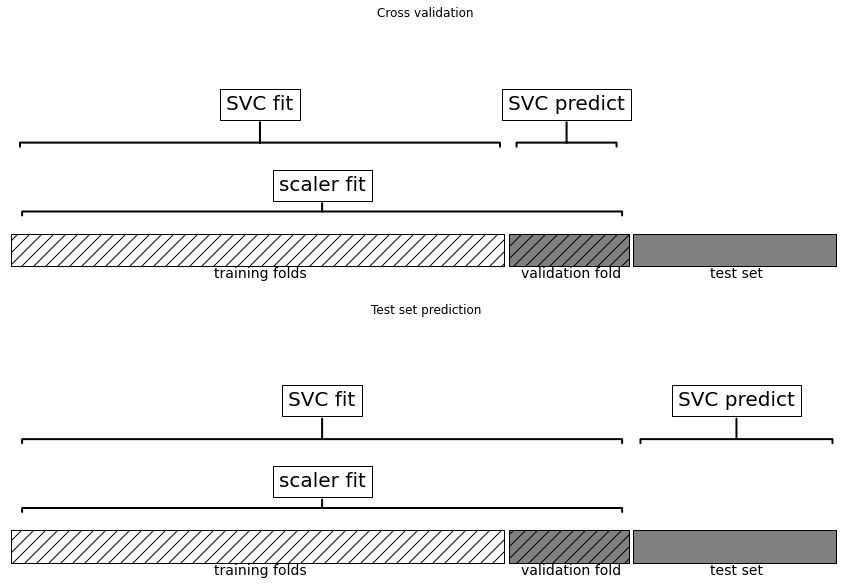

In [21]:
mglearn.plots.plot_improper_processing()

In [22]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC())])

In [23]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('svm', SVC())])

In [24]:
print("Test score: {:.2f}".format(pipe.score(X_test, y_test)))

Test score: 0.97


In [25]:
param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
              'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

In [26]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Test set score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best parameters: {}".format(grid.best_params_))

Best cross-validation accuracy: 0.98
Test set score: 0.97
Best parameters: {'svm__C': 1, 'svm__gamma': 1}


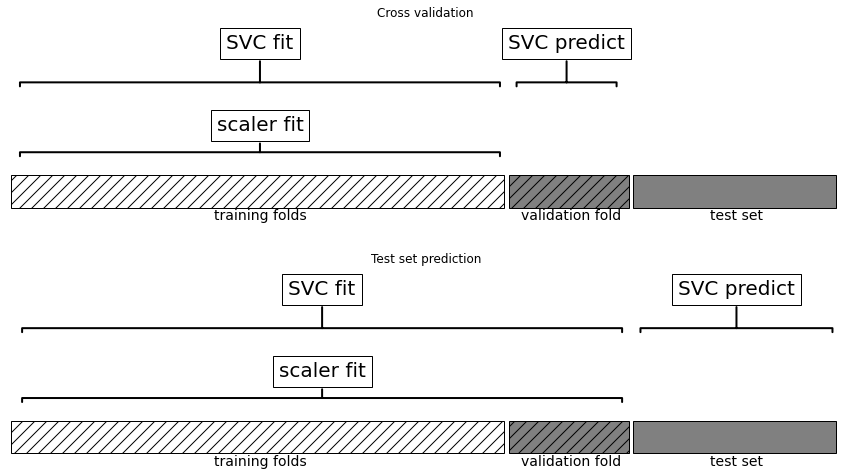

In [27]:
mglearn.plots.plot_proper_processing()

In [33]:
import numpy as np

In [34]:
rnd = np.random.RandomState(seed=0)
X = rnd.normal(size=(100, 10000))
y = rnd.normal(size=(100,))

In [35]:
from sklearn.feature_selection import SelectPercentile, f_regression

select = SelectPercentile(score_func=f_regression, percentile=5).fit(X, y)
X_selected = select.transform(X)
print("X_selected.shape: {}".format(X_selected.shape))

X_selected.shape: (100, 500)


In [36]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
print("Cross-validation accuracy (cv only on ridge): {:.2f}".format(
      np.mean(cross_val_score(Ridge(), X_selected, y, cv=5))))

Cross-validation accuracy (cv only on ridge): 0.91


In [37]:
pipe = Pipeline([("select", SelectPercentile(score_func=f_regression,
                                             percentile=5)),
                 ("ridge", Ridge())])
print("Cross-validation accuracy (pipeline): {:.2f}".format(
      np.mean(cross_val_score(pipe, X, y, cv=5))))

Cross-validation accuracy (pipeline): -0.25


In [38]:
def fit(self, X, y):
    X_transformed = X
    for name, estimator in self.steps[:-1]:
        # iterate over all but the final step
        # fit and transform the data
        X_transformed = estimator.fit_transform(X_transformed, y)
    # fit the last step
    self.steps[-1][1].fit(X_transformed, y)
    return self

In [39]:
def predict(self, X):
    X_transformed = X
    for step in self.steps[:-1]:
        # iterate over all but the final step
        # transform the data
        X_transformed = step[1].transform(X_transformed)
    # predict using the last step
    return self.steps[-1][1].predict(X_transformed)

In [40]:
from sklearn.pipeline import make_pipeline
# standard syntax
pipe_long = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC(C=100))])
# abbreviated syntax
pipe_short = make_pipeline(MinMaxScaler(), SVC(C=100))

In [41]:
print("Pipeline steps:\n{}".format(pipe_short.steps))

Pipeline steps:
[('minmaxscaler', MinMaxScaler()), ('svc', SVC(C=100))]


In [42]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipe = make_pipeline(StandardScaler(), PCA(n_components=2), StandardScaler())
print("Pipeline steps:\n{}".format(pipe.steps))

Pipeline steps:
[('standardscaler-1', StandardScaler()), ('pca', PCA(n_components=2)), ('standardscaler-2', StandardScaler())]


In [43]:
# fit the pipeline defined before to the cancer dataset
pipe.fit(cancer.data)
# extract the first two principal components from the "pca" step
components = pipe.named_steps["pca"].components_
print("components.shape: {}".format(components.shape))

components.shape: (2, 30)


In [44]:
from sklearn.linear_model import LogisticRegression

pipe = make_pipeline(StandardScaler(), LogisticRegression())

In [45]:
param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10, 100]}

In [46]:
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=4)
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

C:\Users\puneeth.samarla\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\puneeth.samarla\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             param_grid={'logisticregression__C': [0.01, 0.1, 1, 10, 100]})

In [47]:
print("Best estimator:\n{}".format(grid.best_estimator_))

Best estimator:
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(C=1))])


In [48]:
print("Logistic regression step:\n{}".format(
      grid.best_estimator_.named_steps["logisticregression"]))

Logistic regression step:
LogisticRegression(C=1)


In [49]:
print("Logistic regression coefficients:\n{}".format(
      grid.best_estimator_.named_steps["logisticregression"].coef_))

Logistic regression coefficients:
[[-0.43570655 -0.34266946 -0.40809443 -0.5344574  -0.14971847  0.61034122
  -0.72634347 -0.78538827  0.03886087  0.27497198 -1.29780109  0.04926005
  -0.67336941 -0.93447426 -0.13939555  0.45032641 -0.13009864 -0.10144273
   0.43432027  0.71596578 -1.09068862 -1.09463976 -0.85183755 -1.06406198
  -0.74316099  0.07252425 -0.82323903 -0.65321239 -0.64379499 -0.42026013]]


In [50]:
from sklearn.datasets import load_boston
boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target,
                                                    random_state=0)

from sklearn.preprocessing import PolynomialFeatures
pipe = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(),
    Ridge())

In [51]:
param_grid = {'polynomialfeatures__degree': [1, 2, 3],
              'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

In [52]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('ridge', Ridge())]),
             n_jobs=-1,
             param_grid={'polynomialfeatures__degree': [1, 2, 3],
                         'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]})

In [54]:
import matplotlib.pyplot as plt

([<matplotlib.axis.YTick at 0x25996c7b5e0>,
 [Text(0, 0, '1'), Text(0, 1, '2'), Text(0, 2, '3')])

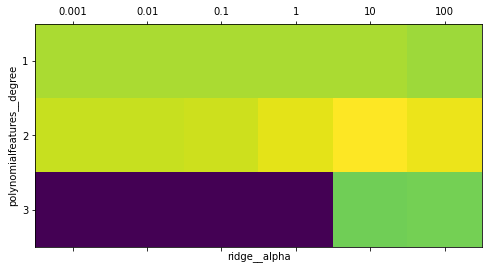

In [55]:
plt.matshow(grid.cv_results_['mean_test_score'].reshape(3, -1),
            vmin=0, cmap="viridis")
plt.xlabel("ridge__alpha")
plt.ylabel("polynomialfeatures__degree")
plt.xticks(range(len(param_grid['ridge__alpha'])), param_grid['ridge__alpha'])
plt.yticks(range(len(param_grid['polynomialfeatures__degree'])),
           param_grid['polynomialfeatures__degree'])

In [56]:
print("Best parameters: {}".format(grid.best_params_))

Best parameters: {'polynomialfeatures__degree': 2, 'ridge__alpha': 10}


In [57]:
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))

Test-set score: 0.77


In [58]:
param_grid = {'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
pipe = make_pipeline(StandardScaler(), Ridge())
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("Score without poly features: {:.2f}".format(grid.score(X_test, y_test)))

Score without poly features: 0.63


In [59]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())])

In [60]:
from sklearn.ensemble import RandomForestClassifier

param_grid = [
    {'classifier': [SVC()], 'preprocessing': [StandardScaler(), None],
     'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
     'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]},
    {'classifier': [RandomForestClassifier(n_estimators=100)],
     'preprocessing': [None], 'classifier__max_features': [1, 2, 3]}]

In [61]:
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

print("Best params:\n{}\n".format(grid.best_params_))
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))

Best params:
{'classifier': SVC(C=10, gamma=0.01), 'classifier__C': 10, 'classifier__gamma': 0.01, 'preprocessing': StandardScaler()}

Best cross-validation score: 0.99
Test-set score: 0.98


In [ ]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())],
                memory="cache_folder")